# 📚 Notebook 5.2: Advanced Training Techniques

Welcome to *Notebook 5.2*! 🎉 In this notebook, we’ll dive into more advanced techniques to supercharge the training of our GPT model. In *Notebook 5.1*, we laid down the basics of training GPT from scratch. Now it’s time to push the boundaries and optimize both performance and scalability.

### What's in store? 🔧

This notebook is divided into three sections, each focusing on a crucial area of optimization:

### **Section 1: Optimizing GPU Performance** 🚀
We’ll explore techniques that leverage GPU power to speed up training, including:
- Tensor core optimization
- Mixed precision training
- torch compile $ Kernel fusion
- Flash attention 


### **Section 2: Algorithmic Optimization & Hyperparameter Tuning** 🎯
In this section, we’ll look at ways to make our training loop more efficient by tweaking hyperparameters and algorithms, such as:
- Learning rate schedules
- AdamW optimizer tweaks
- Gradient accumulation and clipping


### **Section 3: Distributed Data Parallel (DDP) & Multi-GPU Training** 🖥️🖥️
Scaling up your model across multiple GPUs is essential for large-scale training. We’ll cover:
- Distributed Data Parallel (DDP)
- Efficient multi-GPU strategies

---

Let’s get started and dive into the exciting world of advanced GPT training! 💪

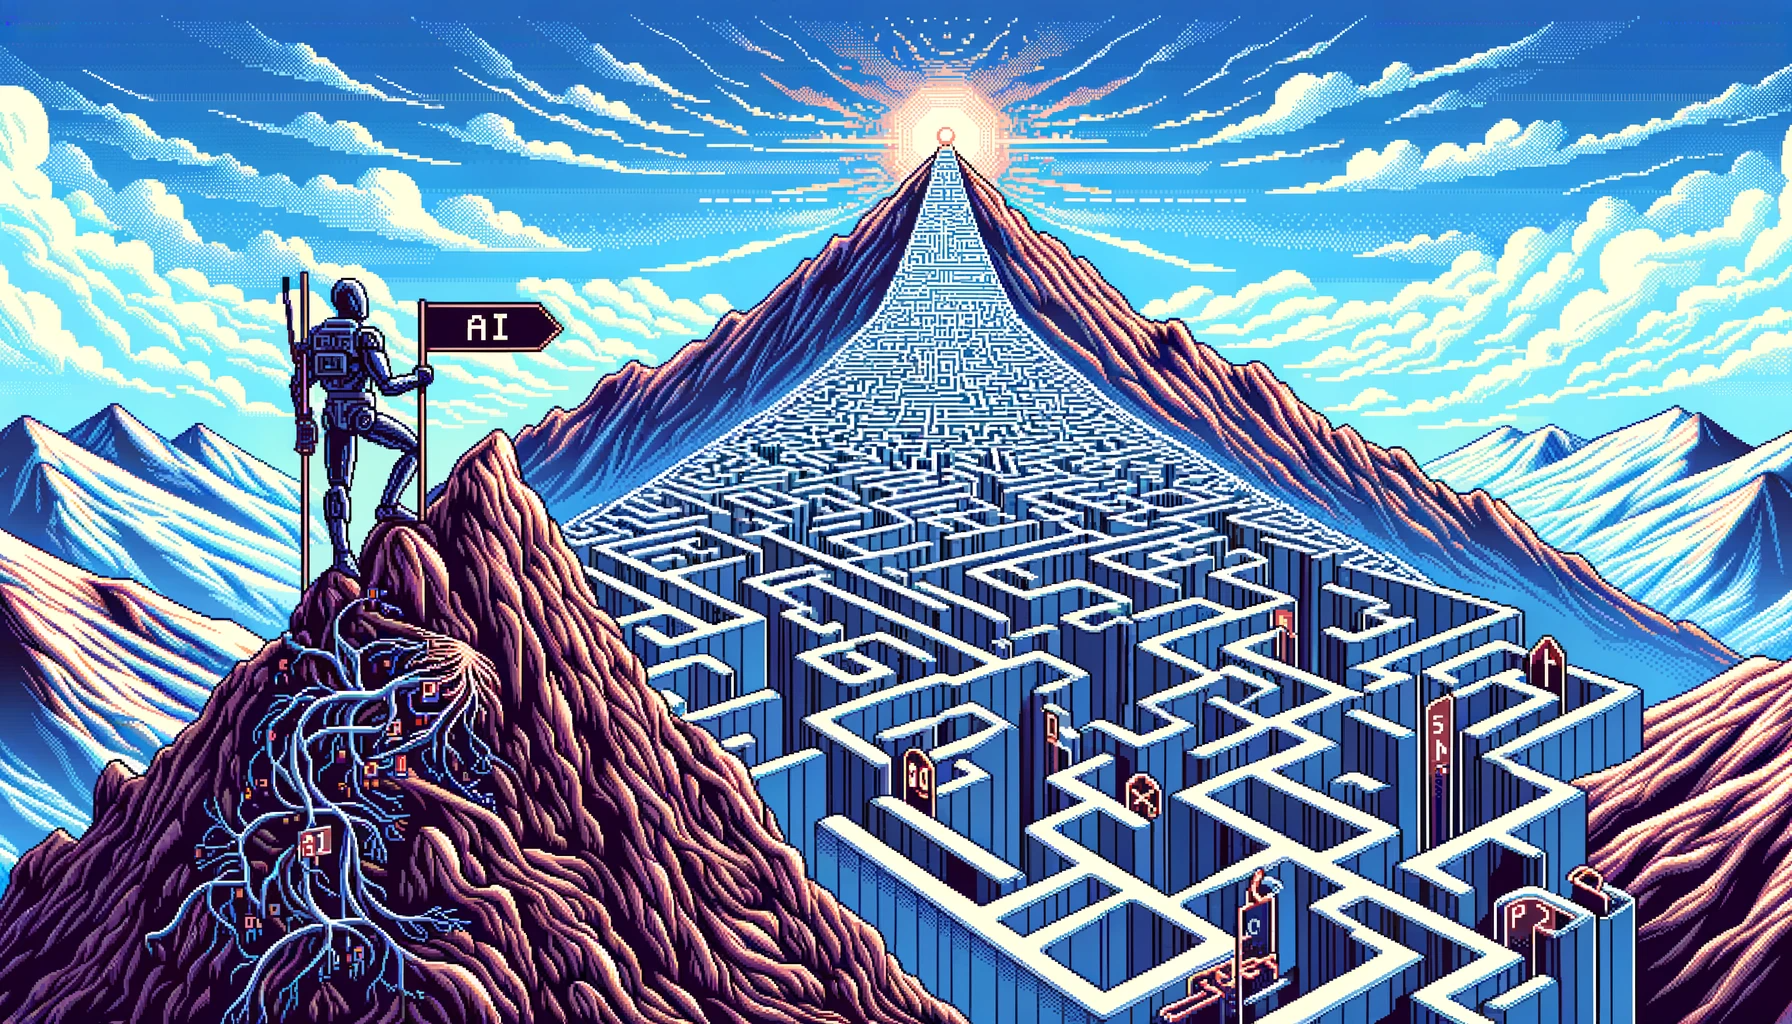

In [10]:
# Uncomment the following line to install tiktoken if you are working in Google Colab
# ! pip install tiktoken 

# Import necessary libraries for the notebook
import numpy as np                # For numerical operations and handling arrays
import torch                       # Main PyTorch library for tensor operations
import torch.nn as nn              # For building neural network modules
import torch.nn.functional as F     # For activation functions and other functional operations
from torch.utils.data import DataLoader, Dataset  # For handling datasets and creating data loaders
import tiktoken                    # For tokenization and encoding text data

# With these imports, we are set to perform various tasks such as:
# - Loading and preprocessing datasets
# - Creating and training neural networks
# - Using tiktoken for effective token management in our GPT model training


In [3]:
# Import PyTorch's Dynamo for runtime optimization
import torch._dynamo

# Suppress runtime errors during the optimization process
# Setting this to True allows Dynamo to ignore non-critical errors 
# that may occur while optimizing the model's execution.
# This can be useful during development and experimentation, 
# but be cautious as it may hide important issues.
torch._dynamo.config.suppress_errors = True

In [11]:
# Let's pour the relevant code from the previous notebooks 

# From notebook 1: Define the GPT2 dataset class
class GPT2Dataset(Dataset):
    def __init__(self, file_path, max_length, stride):
        # Load the binary file into a NumPy array
        self.data = np.fromfile(file_path, dtype=np.int32)
        self.max_length = max_length  # Maximum length of input sequence
        self.stride = stride  # Stride defines how much to slide the window

    def __len__(self):
        # Calculate the total number of samples based on the data length, max_length, and stride
        return (len(self.data) - self.max_length) // self.stride

    def __getitem__(self, idx):
        # Calculate the starting index for the input sequence based on the stride
        start_idx = idx * self.stride

        # Extract the input sequence from the data
        input_seq = self.data[start_idx: start_idx + self.max_length]

        # Extract the output sequence (next tokens) by shifting the input sequence by 1
        output_seq = self.data[start_idx + 1: start_idx + self.max_length + 1]

        # Convert the input and output sequences to PyTorch tensors
        input_seq = torch.tensor(input_seq, dtype=torch.long)
        output_seq = torch.tensor(output_seq, dtype=torch.long)

        return input_seq, output_seq

# File paths for training, validation, and test datasets
train_path = "data/train_ids.bin"
val_path = "data/val_ids.bin"
test_path = "data/test_ids.bin"

# Set random seed for reproducibility
torch.manual_seed(123)

# Create instances of the dataset for training, validation, and testing
train_dataset = GPT2Dataset(train_path, max_length=512, stride=128)
val_dataset = GPT2Dataset(val_path, max_length=512, stride=128)
test_dataset = GPT2Dataset(test_path, max_length=512, stride=128)

# Create DataLoader for batching, shuffling, and dropping incomplete batches
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, drop_last=True)

# Calculate the total number of tokens in the training dataset
train_tokens = 0
for input_batch, target_batch in train_dataloader:
    train_tokens += input_batch.numel()

# Calculate the total number of tokens in the validation dataset
val_tokens = 0
for input_batch, target_batch in val_dataloader:
    val_tokens += input_batch.numel()

# Calculate the total number of tokens in the test dataset
test_tokens = 0
for input_batch, target_batch in test_dataloader:
    test_tokens += input_batch.numel()

# Print dataset statistics
print("THE DATASET:")
print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("Test tokens:", test_tokens)
print("All tokens:", train_tokens + val_tokens + test_tokens)

############################################################################################################################################### 

# GPT2 configuration dictionary
GPT_CONFIG_124 = {
    "vocab_size": 50257,        # The number of tokens the model can understand (including special tokens like <|endoftext|>)
    "context_length": 1024,      # Maximum number of tokens the model can handle at once (sequence length)
    "emb_dim": 768,             # Dimension of the embeddings and hidden states (controls model's capacity)
    "n_head": 12,               # Number of attention heads in each layer (parallel attention mechanisms)
    "n_layer": 12,              # Number of transformer layers (stacked attention layers with feed-forward networks)
    "dropout": 0.1,             # Dropout rate to regularize the model and prevent overfitting
    "qkv_bias": False,          # Whether to include bias in the linear layers of query, key, and value projections
}

##############################################################################################################################################

# From notebook 3: Define the FeedForward neural network class
class FeedForward(nn.Module):
    def __init__(self, config):
        # Call the parent class constructor
        super().__init__()

        # Define a sequential model with two linear layers and a GELU activation function
        self.layers = nn.Sequential(
            nn.Linear(config['emb_dim'], 4 * config['emb_dim']),  # First linear layer
            nn.GELU(),                                             # Activation function
            nn.Linear(4 * config['emb_dim'], config['emb_dim'])  # Second linear layer
        )

    def forward(self, x):
        # Forward pass: apply the sequential layers to the input x
        return self.layers(x)

# Now we have it all to implement the transformer block
# Don't forget our MultiHeadAttention implementation from the previous notebook

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)  # Ensure output dimension is divisible by number of heads
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Dimension of each attention head

        # Define linear layers for queries, keys, and values
        self.W_query = nn.Linear(d_in, d_out, bias=bias)
        self.W_key = nn.Linear(d_in, d_out, bias=bias)
        self.W_value = nn.Linear(d_in, d_out, bias=bias)
        
        self.dropout = nn.Dropout(dropout)  # Dropout layer for regularization
        self.proj = nn.Linear(d_out, d_out)  # Final linear projection layer
        
        # Register a buffer for the upper triangular mask (causal attention)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape  # Unpack input shape

        # Compute queries, keys, and values
        keys = self.W_key(x)
        values = self.W_value(x)
        queries = self.W_query(x)

        # Reshape and transpose for multi-head attention
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        # Calculate attention scores
        attention_scores = queries @ keys.transpose(2, 3)  # Shape: (batch_size, num_heads, num_tokens, num_tokens)
        
        # Apply the attention mask
        mask_bool = self.mask[:num_tokens, :num_tokens].bool()
        attention_scores.masked_fill_(mask_bool, -torch.inf)  # Mask out future tokens

        # Compute attention weights
        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)  # Apply dropout to attention weights

        # Aggregate the attention outputs
        all_con_vec = (attention_weights @ values).transpose(1, 2).contiguous().view(b, num_tokens, self.d_out)

        # Project the concatenated outputs
        output = self.proj(all_con_vec)
        return output

# Now let's implement the transformer block
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Initialize the multi-head attention layer
        self.attention = MultiHeadAttention(
            d_in=config["emb_dim"],              # Input dimension
            d_out=config["emb_dim"],             # Output dimension
            context_length=config["context_length"],  # Length of the context
            dropout=config["dropout"],            # Dropout rate
            num_heads=config["n_head"],           # Number of attention heads
            bias=config["qkv_bias"]               # Whether to include bias in Q, K, V
        )

        # Initialize the feedforward layer
        self.feedforward = FeedForward(config)

        # Initialize layer normalization layers
        self.norm1 = nn.LayerNorm(config["emb_dim"])  # First normalization layer
        self.norm2 = nn.LayerNorm(config["emb_dim"])  # Second normalization layer

        # Initialize dropout layer
        self.dropout = nn.Dropout(config["dropout"])  # Dropout layer for regularization

    def forward(self, x):
        # Save the original input for skip connection
        shortcut = x

        # Apply first layer normalization
        x = self.norm1(x)

        # Apply multi-head attention
        x = self.attention(x)

        # Apply dropout after attention
        x = self.dropout(x)

        # Add the skip connection (shortcut) from the original input
        x = shortcut + x

        # Save the output for the next skip connection
        shortcut = x

        # Apply second layer normalization
        x = self.norm2(x)

        # Apply feedforward layer
        x = self.feedforward(x)

        # Apply dropout after feedforward
        x = self.dropout(x)

        # Add the skip connection (shortcut) again
        x = shortcut + x

        return x  # Return the output of the transformer block

# Define the GPT model
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Define the embedding layer for token representations
        self.token_embeddings = nn.Embedding(config["vocab_size"], config["emb_dim"])
        
        # Define a list of transformer blocks
        self.transformer_blocks = nn.ModuleList([TransformerBlock(config) for _ in range(config["n_layer"])])
        
        # Define the final linear layer for generating output logits
        self.output_layer = nn.Linear(config["emb_dim"], config["vocab_size"])

    def forward(self, x):
        # Get token embeddings for the input tokens
        x = self.token_embeddings(x)

        # Pass through each transformer block
        for block in self.transformer_blocks:
            x = block(x)

        # Compute the final output logits
        x = self.output_layer(x)
        return x  # Return the output logits


print("\n")
model = GPTModel(GPT_CONFIG_124)
print("THE MODEL IS:\n")
print(model)


THE DATASET:
Training tokens: 1583104
Validation tokens: 122880
Test tokens: 51200
All tokens: 1757184


THE MODEL IS:

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trans_blk): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedforward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05,

In [12]:
# Define a function to calculate the loss for a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
    # Move input and target batches to the appropriate device (CPU/GPU)
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # Forward pass: Get model predictions (logits) for the input batch
    logits = model(input_batch)

    # Calculate the cross-entropy loss by flattening logits and targets
    # Cross-entropy loss is commonly used for classification tasks, especially in language modeling
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

    return loss  # Return the computed loss


# Define a function to calculate the average loss over a specified number of batches from the data loader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.  # Initialize total loss to zero

    # Check if the data loader is empty and return NaN if it is
    if len(data_loader) == 0:
        return float("nan")  # Return NaN for empty data loader

    # Determine the number of batches to process
    elif num_batches is None:
        num_batches = len(data_loader)  # Use all batches if none specified
    else:
        # Ensure num_batches does not exceed the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    # Iterate through the batches in the data loader
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:  # Process only up to the specified number of batches
            # Calculate loss for the current batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()  # Accumulate the loss
        else:
            break  # Exit the loop if the specified number of batches has been processed

    # Return the average loss across the specified number of batches
    return total_loss / num_batches

# Explanation:
# 1. The `calc_loss_batch` function computes the loss for a single batch of input and target sequences.
# 2. It utilizes cross-entropy loss, which is standard for classification tasks, particularly in language models.
# 3. The `calc_loss_loader` function computes the average loss over multiple batches provided by the data loader.
# 4. It allows for flexible evaluation by specifying the number of batches to process, or defaults to all available batches.
# 5. If the data loader is empty, it returns NaN, ensuring robust error handling.
# 6. The functions leverage PyTorch's capabilities to efficiently move data to the appropriate device (CPU or GPU).


In [14]:
## Model Evaluation helper function
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    Evaluates the model's performance on the training and validation datasets.

    Args:
        model: The model to evaluate.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        device: The device (CPU or GPU) to perform computations on.
        eval_iter: Number of batches to use for evaluation.

    Returns:
        train_loss: Average loss on the training dataset.
        val_loss: Average loss on the validation dataset.
    """
    model.eval()  # Set the model to evaluation mode to disable dropout and batch normalization
    with torch.no_grad():  # Disable gradient tracking for efficiency during evaluation
        # Calculate the average loss for the training dataset
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        # Calculate the average loss for the validation dataset
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()  # Set the model back to training mode for further training
    return train_loss, val_loss  # Return the computed training and validation losses


# TIME OUT! 🎉

**Wowza! What a coding adventure we just had!** 🚀 It feels like we've journeyed from zero to hero with this project! Every line of code we poured out is a step closer to our grand vision. From the early brainstorming sessions to these intricate functions, it’s like watching a masterpiece unfold! 🖥️💥 

Here’s to our progress and the exciting road ahead—let’s keep this momentum going! Cheers to us and our coding escapades! 🥳🎈

NOW LETS GET BACK TO IT ---->

In [8]:

# The following command will display the current status of the NVIDIA GPU, including memory usage and active processes.(colab)

! nvidia-smi

Wed Oct 23 16:17:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### **Section 1: Optimizing GPU Performance** 🚀
We’ll explore techniques that leverage GPU power to speed up training, including:

1- Tensor core optimization 
2- Mixed precision training
3- torch compile $ Kernel fusion
4- Flash attention 

## 1- Tensor core optimization
## So what are tensorcore anyway : 

In the world of deep learning, performance is key, and **TensorCores** are a game-changer. These specialized instruction sets, found in modern NVIDIA GPUs, are engineered specifically to accelerate matrix multiplication operations. 

### Why Matrix Multiplication?

Matrix multiplication is at the heart of many deep learning models, especially transformer architectures like **GPT (Generative Pre-trained Transformer)**. In these models, the core computations are largely centered around linear layers that perform extensive matrix multiplications. This is where TensorCores truly excel.

### The 4x4 Matrix Multiplication Advantage

TensorCores are optimized for performing 4x4 matrix multiplications, allowing them to handle computations faster than traditional processing units. By leveraging this specialized hardware, GPT models can process vast amounts of data at lightning speed, dramatically reducing training times and enhancing performance during inference.

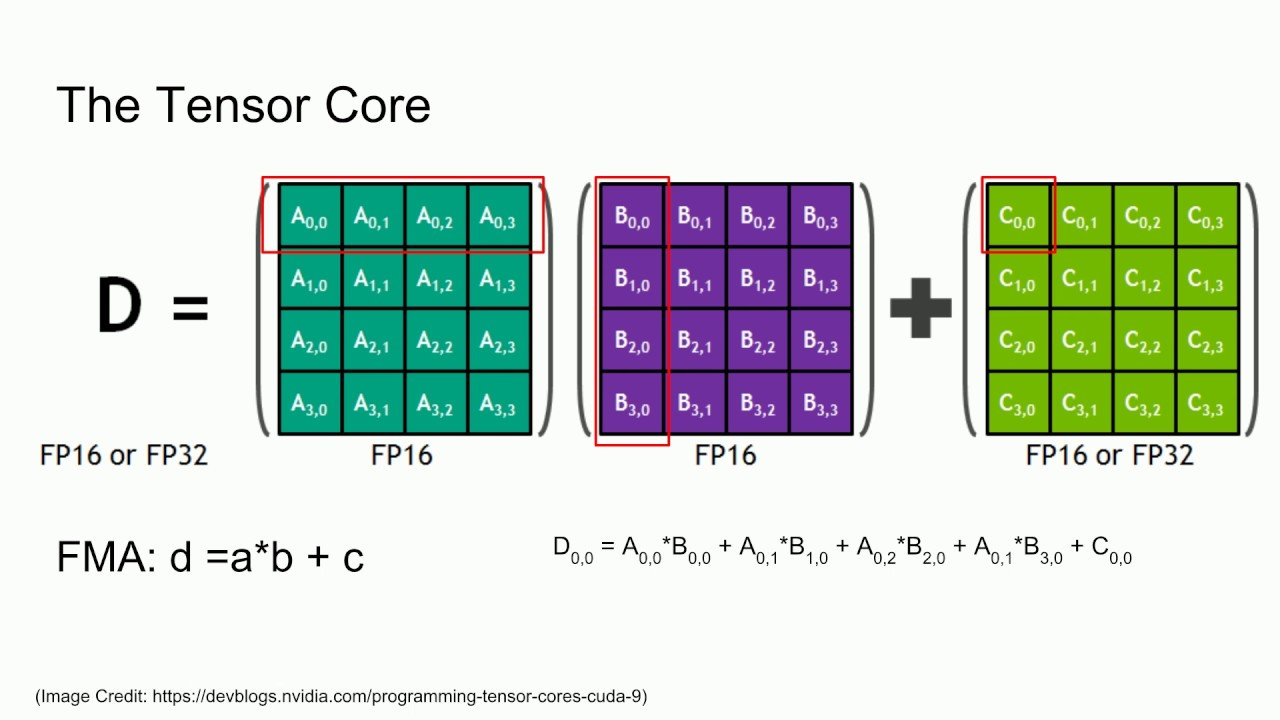




### 2 - FP32 vs. TF32 Precision

In the world of deep learning, precision plays a crucial role in balancing performance and accuracy. 

- **FP32 (32-bit Floating Point)**: The default precision used in PyTorch. It offers high accuracy but can be computationally expensive, especially when training large models.

- **TF32 (TensorFloat 32)**: Introduced by TensorFlow, TF32 serves as the default precision and provides a compelling trade-off between speed and precision. 

When using **TF32**, the floating-point precision of matrix multiplication operations, which are handled by specialized **TensorCores**, is slightly cropped. Although this results in a minor loss of precision, it can lead to an **8x performance improvement**! This means that by sacrificing a small amount of accuracy, practitioners can achieve significant speed gains—a crucial advantage when training large-scale models.

This **sweet spot** makes TF32 particularly valuable in the context of modern AI applications, where efficiency is key to handling the complexity and size of contemporary neural networks.


<p align="center">
    <img src="images/TF32.png" alt="My Image" />
</p>


Lets see how to implement tf32 in pytorch :

In [15]:
# Enabling TF32 Precision in PyTorch

# This line of code enables TensorFloat-32 (TF32) precision for matrix multiplication
# in PyTorch, which allows the model to leverage the speed of TensorCores on compatible GPUs.
torch.set_float32_matmul_precision('high')

# Explanation:
# The 'high' setting for set_float32_matmul_precision allows all matrix multiplications 
# (such as those in linear layers) to utilize TF32 precision.
#
# While we aim for an impressive 8x performance improvement with TF32, the actual performance
# gain is generally around 3x. This discrepancy arises because, even though the matrix 
# multiplication is optimized for TF32, other operations still execute in FP32.
# These operations may require additional time for data transfers. Nevertheless, achieving 
# a 3x boost without any extra cost is a significant advantage in training large models!


### Mixed Precision: Dropping Even Lower - FB16 & FP16

As we continue to optimize model performance, leveraging even lower precision formats like `FP16` (16-bit floating-point) can lead to significant speedups. While dropping to `FP16` can enhance computational efficiency, it also reduces numerical accuracy. This trade-off allows for faster training times and decreased memory usage, making it especially valuable when working with large-scale models.

However, one important consideration when using `FP16` is the potential for numerical instability during the training process(hint 1 : to understand why look at the figure above ans notice where the croping happen). To mitigate this issue, gradient scaling is often employed. Gradient scaling involves multiplying the gradients by a constant factor before the backward pass, which helps to preserve the range of gradient values and prevents underflow.

An alternative to `FP16` is `BF16` (bfloat16) precision. `BF16` retains the same number of exponent bits as `FP32`, which helps maintain numerical stability (hint 2 : look where the croping happen in the figure above) while still offering a reduction in memory usage and computational requirements. This makes `BF16` a compelling choice, as it allows you to enjoy some of the benefits of lower precision without the same degree of risk for numerical instability.

In summary, both `FP16` and `BF16` present excellent options for optimizing deep learning models, providing a pathway to improved performance while navigating the challenges of numerical accuracy and stability. Choosing the right precision format can be crucial depending on the specific requirements of your model and training environment.

## In summary we arrive at the conclusion that our "sweet spot" is BF16 , now lets impement it in pytorch :  

In [ ]:
import torch

loss_function = torch.nn.CrossEntropyLoss()

# Enable mixed precision for computations
# Note: This should be applied only to the forward pass and loss calculations, not the backward pass.
# Mixed precision optimizations are available only on NVIDIA's Ampere architecture (not Volta).
with torch.autocast(device_type="cuda", dtype=torch.float16):
    # Forward pass: Perform a forward pass through the model
    logits = model(input_batch)  # Replace 'model' and 'input_batch' with your actual model and input

    # Calculate loss
    loss = loss_function(logits, target_batch)  # Replace 'loss_function' with your actual loss function

# Important: The backward pass should be performed in FP32 to maintain numerical stability
# in other words, DONT USE torch.autocast with the backward pass.



### 3- Heavy Artillery: `torch.compile()`

For even greater performance enhancements, PyTorch offers `torch.compile()`, which requires just a single line of code:

```python
model = torch.compile(model)
```

By adding a small compilation overhead, this feature can lead to substantial performance improvements overall. It is advisable to use `torch.compile()` by default unless you're actively debugging your code.

#### Under the Hood: What's Happening?

<p align="center">
    <img src="images/gpu.png" alt="My Image" />
</p>


The primary speed-up from `torch.compile()` arises from reducing Python overhead and optimizing GPU read/write operations. When you compile your model, PyTorch performs an analysis of your entire codebase, determining which operations need to be executed and scheduling them to minimize round trips between memory and the GPU. This ensures that your computations are not only faster but also more efficient.

Consider this simplified implementation of the `GELU` activation function:

```python
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
```

With `torch.compile()`, PyTorch analyzes the entire function and executes the sequence of operations in the most efficient manner possible—essentially performing fewer memory transfers between the CPU and GPU. Without the use of `torch.compile()`, each operation (for example, `torch.sqrt(2.0)`) could result in multiple memory-GPU transfers, leading to slower performance due to the overhead of Python's execution model.

This type of optimization is referred to as *kernel fusion*. It merges multiple operations into a single, more efficient one, thus minimizing overhead and boosting overall performance.


### 4- Flash Attention: A Breakthrough Optimization

One groundbreaking example of algorithmic optimization in the realm of transformer architectures is **Flash Attention**. This innovative approach optimizes the traditional attention mechanism, which is a key component of models like GPT and BERT. 

#### What is Flash Attention?

Flash Attention is designed to improve the efficiency of the attention computation by employing an online softmax computation. Unlike the standard attention mechanism that may involve a significant amount of overhead, Flash Attention streamlines this process, resulting in faster computations and reduced memory usage. 

The main idea behind Flash Attention is to compute attention scores dynamically during the forward pass, which allows for more efficient handling of long sequences—critical for training large language models.

#### Implementation of Flash Attention

In PyTorch, Flash Attention can be implemented as follows:

```python
import torch.nn.functional as F

# Compute the scaled dot-product attention using Flash Attention
y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, is_causal=True)
```

In this implementation:
- `q`, `k`, and `v` represent the query, key, and value tensors, respectively.
- The `attn_mask` parameter allows for masking certain positions in the input, which is useful for tasks such as autoregressive generation.
- The `is_causal` flag indicates whether the attention should be causal, preventing the model from attending to future tokens in a sequence.

#### Why Does it Matter?

The introduction of Flash Attention is a game-changer, especially for models heavily reliant on attention mechanisms. It can yield significant speed improvements and lower memory consumption, making it particularly valuable for training large-scale models where efficiency is paramount.

For more in-depth information on Flash Attention and its implementation, you can refer to the following papers:

- **FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Aware Kernels** (Paper link: https://arxiv.org/abs/2205.14135)

ok lets re-implemt the model with flash attention : 

In [17]:
# Define the FeedForward neural network class
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(config['emb_dim'], 4 * config['emb_dim']),
            nn.GELU(),
            nn.Linear(4 * config['emb_dim'], config['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)


### Highlighted Changes: FlashAttention Class
class FlashAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, bias=False):
        super().__init__()
        assert (d_out % num_heads == 0)
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=bias)
        self.W_key = nn.Linear(d_in, d_out, bias=bias)
        self.W_value = nn.Linear(d_in, d_out, bias=bias)
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(d_out, d_out)
        
        # Added boolean mask for causal attention
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        values = self.W_value(x)
        queries = self.W_query(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)  # (b, num_heads, num_tokens, head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)  # (b, num_heads, num_tokens, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)  # (b, num_heads, num_tokens, head_dim)

        # Use F.scaled_dot_product_attention for optimized attention calculation
        attn_mask = self.mask[:num_tokens, :num_tokens].bool()  # Create boolean mask
        attention_output = F.scaled_dot_product_attention(queries, keys, values, attn_mask=attn_mask, is_causal=True)

        # Reshape output back to original format
        output = attention_output.transpose(1, 2).contiguous().view(b, num_tokens, self.d_out)  # (b, num_tokens, d_out)

        return self.proj(output)  # Project the output


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Changed to use FlashAttention
        self.attention = FlashAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            dropout=config["dropout"],
            num_heads=config["n_head"],
            bias=config["qkv_bias"]
        )

        self.feedforward = FeedForward(config)
        self.norm1 = nn.LayerNorm(config["emb_dim"])
        self.norm2 = nn.LayerNorm(config["emb_dim"])
        self.dropout = nn.Dropout(config["dropout"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)  # Updated to use FlashAttention
        x = self.dropout(x)
        x = shortcut + x

        shortcut = x
        x = self.norm2(x)
        x = self.feedforward(x)
        x = self.dropout(x)
        x = shortcut + x

        return x

class GPTModel_FLASH(nn.Module):
    def __init__(self, config):
        super(GPTModel_FLASH, self).__init__()

        self.token_embedding = nn.Embedding(config['vocab_size'], config['emb_dim'])
        self.position_embedding = nn.Embedding(config['context_length'], config['emb_dim'])
        self.dropout = nn.Dropout(config['dropout'])

        self.trans_blk = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config['n_layer'])]  # Utilizing the updated TransformerBlock
        )

        self.layerNorm = nn.LayerNorm(config['emb_dim'])
        self.output = nn.Linear(config['emb_dim'], config['vocab_size'])

    def forward(self, x):
        token_embeddings = self.token_embedding(x)
        position_indices = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        position_embeddings = self.position_embedding(position_indices)
        embeddings = token_embeddings + position_embeddings
        embeddings = self.dropout(embeddings)

        transformer_output = self.trans_blk(embeddings)
        normalized_output = self.layerNorm(transformer_output)
        logits = self.output(normalized_output)

        return logits


### Bounus : Power of Two Optimization

GPU architecture is often optimized for powers of two. Replacing "ugly" numbers with those that align with powers of two can result in faster computations. As Andrej Karpathy humorously notes, "We add calculations, but it goes faster!"

#### Why Power of Two?

Using powers of two (e.g., 2, 4, 8, 16, 32, etc.) for dimensions in neural networks or batch sizes can exploit the underlying hardware better. Many GPU operations are optimized to handle these sizes more efficiently, which can lead to improved performance.

### Practical Example

When setting the batch size or defining layer dimensions, try using powers of two. For instance, instead of using a batch size of 10 or 20, you can set it to 16 or 32. This can help leverage the GPU’s architecture for better throughput.

```python
# Example of setting batch size in a DataLoader
batch_size = 32  # Power of two

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


## Performance Comparison: Baseline vs. Optimized Version

Before diving into Section Two, let's run a performance comparison between the baseline performance established in the previous notebook (`trainerV1`) and the new optimized version (`trainerV2`). We will calculate the time taken for each step of the training process to quantify the improvements made with the enhancements.

### Steps for Performance Measurement

1. **Setup**: Ensure that both versions of the trainer are properly set up in the environment. Confirm that the same dataset, model architecture, and hyperparameters are used for both versions.

2. **Timing Each Step**: Use Python's built-in `time` module to measure the duration of critical steps in the training process, such as data loading, forward pass, loss calculation, backward pass, and optimization. 


In [9]:
import time

# the basic training function from the previuos notebook
def trainerV1(model, train_loader, val_loader, optimizer, device, num_epochs,
               eval_freq, eval_iter, start_context, tokenizer, save_path):
    """
    Trains the model over a specified number of epochs, evaluating its performance at regular intervals.

    Args:
        model: The model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        optimizer: The optimizer for updating model parameters.
        device: The device (CPU or GPU) to perform computations on.
        num_epochs: Total number of training epochs.
        eval_freq: Frequency of evaluation (in steps).
        eval_iter: Number of batches to use for evaluation.
        start_context: Initial context for text generation.
        tokenizer: Tokenizer used to encode and decode text.
        save_path: Directory to save the model checkpoints.

    Returns:
        train_losses: List of training losses over the epochs.
        val_losses: List of validation losses over the epochs.
        track_tokens_seen: List of total tokens seen during training.
    """

    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1  # Track total tokens and global training steps

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode to enable dropout and batch normalization

        for input_batch, target_batch in train_loader:
            step_start_time = time.time()  # Start time for the current step

            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Calculate the loss
            loss.backward()  # Backpropagate to calculate gradients
            optimizer.step()  # Update model weights using the calculated gradients

            tokens_seen += input_batch.numel()  # Count the total number of tokens processed
            global_step += 1  # Increment the global step counter

            # Optional evaluation step
            if global_step % eval_freq == 0:  # Evaluate the model at specified intervals
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)  # Store training loss
                val_losses.append(val_loss)  # Store validation loss
                track_tokens_seen.append(tokens_seen)  # Store total tokens seen


            # Calculate the step duration
            step_duration = time.time() - step_start_time
            print(f"Step {global_step:06d} completed in {step_duration:.2f} seconds.")

        # Save the model after each epoch
        torch.save(model.state_dict(), f"{save_path}/gpt_model_epoch_{epoch + 1}.pt")
        print(f"Model saved after epoch {epoch + 1}.")


    return train_losses, val_losses, track_tokens_seen  # Return losses and token tracking information


In [11]:
torch.cuda.empty_cache()

In [12]:
# Note:
# Uncomment the following code to calculate the execution time
import time

# Start the timer to measure execution time
start_time = time.time()

# Set device to GPU if available; otherwise, use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"


# Set a manual seed for reproducibility
torch.manual_seed(123)

# Initialize the model and move it to the specified device
model = GPTModel(GPT_CONFIG_124)
model.to(device)

# Set up the AdamW optimizer with specified learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# Initialize the tokenizer for encoding and decoding text
tok = tiktoken.encoding_for_model("gpt2")

# Define the number of epochs for training
num_epochs = 1

# Define the path to save the model checkpoints in a subdirectory
save_path = "checkpoints"  # Subdirectory for saving model checkpoints

# Ensure the save directory exists
import os
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

# Call the training function and store the resulting losses and tokens seen
train_losses, val_losses, tokens_seen = trainerV1(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,  # Evaluate every 5 steps
    eval_iter=5,  # Use 5 batches for evaluation
    start_context="Be Humble",  # Initial context for text generation
    tokenizer=tok,  # Tokenizer for text processing
    save_path=save_path  # Path for saving the model checkpoints
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()

# Calculate the total execution time in minutes
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Step 000000 completed in 2.04 seconds.
Step 000001 completed in 0.06 seconds.
Step 000002 completed in 0.26 seconds.
Step 000003 completed in 0.22 seconds.
Step 000004 completed in 0.27 seconds.
Step 000005 completed in 0.98 seconds.
Step 000006 completed in 0.05 seconds.
Step 000007 completed in 0.26 seconds.
Step 000008 completed in 0.20 seconds.
Step 000009 completed in 0.27 seconds.
Step 000010 completed in 1.04 seconds.
Step 000011 completed in 0.06 seconds.
Step 000012 completed in 0.25 seconds.
Step 000013 completed in 0.32 seconds.
Step 000014 completed in 0.17 seconds.
Step 000015 completed in 1.01 seconds.
Step 000016 completed in 0.02 seconds.
Step 000017 completed in 0.24 seconds.
Step 000018 completed in 0.23 seconds.
Step 000019 completed in 0.24 seconds.
Step 000020 completed in 1.05 seconds.
Step 000021 completed in 0.03 seconds.
Step 000022 completed in 0.24 seconds.
Step 000023 completed in 0.24 seconds.
Step 000024 completed in 0.24 seconds.
Step 000025 completed in 

KeyboardInterrupt: 

In [13]:
# This version 2 of the training loop with more efficient optimization added, every new line highlighted by [NEW]
# Specifically, in this training loop we added mixed precision with torch.autocast()
# Other additions you will encounter in the next cell where we call:
# - The new model with the Flash Attention added (GPTModel_Flash)
# - In addition, we call torch.compile() on the flash model

def trainerV2(model, train_loader, val_loader, optimizer, device, num_epochs,
               eval_freq, eval_iter, start_context, tokenizer, save_path):
    """
    Trains the model over a specified number of epochs, evaluating its performance at regular intervals.

    Args:
        model: The model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        optimizer: The optimizer for updating model parameters.
        device: The device (CPU or GPU) to perform computations on.
        num_epochs: Total number of training epochs.
        eval_freq: Frequency of evaluation (in steps).
        eval_iter: Number of batches to use for evaluation.
        start_context: Initial context for text generation.
        tokenizer: Tokenizer used to encode and decode text.
        save_path: Directory to save the model checkpoints.

    Returns:
        train_losses: List of training losses over the epochs.
        val_losses: List of validation losses over the epochs.
        track_tokens_seen: List of total tokens seen during training.
    """

    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1  # Track total tokens and global training steps

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode to enable dropout and batch normalization

        # **[NEW] Mixed precision setup**: Use mixed precision scaling for faster training and lower memory usage
        scaler = torch.cuda.amp.GradScaler()

        for input_batch, target_batch in train_loader:
            step_start_time = time.time()  # Start time for the current step

            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration

            # **[NEW] Mixed precision context**: Run calculations in FP16 for efficiency
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                loss = calc_loss_batch(input_batch, target_batch, model, device)  # Calculate the loss

            # **[NEW] Scaled backward pass**: Using GradScaler to safely handle mixed precision
            scaler.scale(loss).backward()  # Backpropagate to calculate gradients
            scaler.step(optimizer)  # Update model weights using the calculated gradients
            scaler.update()  # Update the scaler for next iteration

            tokens_seen += input_batch.numel()  # Count the total number of tokens processed
            global_step += 1  # Increment the global step counter

            # Optional evaluation step
            if global_step % eval_freq == 0:  # Evaluate the model at specified intervals
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)  # Store training loss
                val_losses.append(val_loss)  # Store validation loss
                track_tokens_seen.append(tokens_seen)  # Store total tokens seen

            # Calculate the step duration
            step_duration = time.time() - step_start_time
            print(f"Step {global_step:06d} completed in {step_duration:.2f} seconds.")

        # Save the model after each epoch
        torch.save(model.state_dict(), f"{save_path}/gpt_model_epoch_{epoch + 1}.pt")
        print(f"Model saved after epoch {epoch + 1}.")


    return train_losses, val_losses, track_tokens_seen  # Return losses and token tracking information



In [14]:
# This version uses the same hyperparameters used to train GPT-2 and GPT-3, 
# including beta1 and beta2 for the AdamW optimizer.
# Additionally, this version includes efficient optimization with mixed precision and Flash Attention.

# Note:
# **[NEW] Compilation for optimization**: Compiles the model for faster execution
import time

# Start the timer to measure execution time
start_time = time.time()

# Set device to GPU if available; otherwise, use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set a manual seed for reproducibility
torch.manual_seed(123)

# **[NEW] Model compilation**: Compiling the model for better performance
model = GPTModel_FLASH(GPT_CONFIG_124)
model = torch.compile(model)  # Compile model for faster execution
model.to(device)

# **[NEW] AdamW optimizer with GPT-2 and GPT-3 hyperparameters**:
# Setting beta1 and beta2 for the AdamW optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1,
    betas=(0.9, 0.95)  # [NEW] These are the same beta values used to train GPT-2 and GPT-3
)

# Initialize the tokenizer for encoding and decoding text
tok = tiktoken.encoding_for_model("gpt2")

# Define the number of epochs for training
num_epochs = 1

# Define the path to save the model checkpoints in a subdirectory
save_path = "checkpoints"  # Subdirectory for saving model checkpoints

# Ensure the save directory exists
import os
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

# Call the training function and store the resulting losses and tokens seen
train_losses, val_losses, tokens_seen = trainerV2(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,  # Evaluate every 5 steps
    eval_iter=5,  # Use 5 batches for evaluation
    start_context="Be Humble",  # Initial context for text generation
    tokenizer=tok,  # Tokenizer for text processing
    save_path=save_path  # Path for saving the model checkpoints
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()

# Calculate the total execution time in minutes
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# NOTE : the first iteration is taking longer becuase torch.compile() but after that the traininn will speed up showing the result of our optimization techniques 

Step 000000 completed in 42.80 seconds.
Step 000001 completed in 0.02 seconds.
Step 000002 completed in 0.24 seconds.
Step 000003 completed in 0.24 seconds.
Step 000004 completed in 0.24 seconds.
Step 000005 completed in 1.12 seconds.
Step 000006 completed in 0.03 seconds.
Step 000007 completed in 0.23 seconds.
Step 000008 completed in 0.24 seconds.
Step 000009 completed in 0.24 seconds.
Step 000010 completed in 1.17 seconds.
Step 000011 completed in 0.06 seconds.
Step 000012 completed in 0.23 seconds.
Step 000013 completed in 0.34 seconds.
Step 000014 completed in 0.30 seconds.
Step 000015 completed in 1.09 seconds.
Step 000016 completed in 0.11 seconds.
Step 000017 completed in 0.17 seconds.
Step 000018 completed in 0.24 seconds.
Step 000019 completed in 0.23 seconds.
Step 000020 completed in 1.13 seconds.
Step 000021 completed in 0.02 seconds.
Step 000022 completed in 0.25 seconds.


KeyboardInterrupt: 

### **Section 2: Algorithmic Optimization & Hyperparameter Tuning** 🎯

In this section, we’ll explore techniques to optimize our training loop and fine-tune hyperparameters, including:

- Learning rate schedules
- AdamW optimizer improvements
- Gradient accumulation and clipping

We'll be leveraging the same hyperparameters and techniques used by **GPT-2 & GPT-3** models to achieve optimal performance:

---

#### **AdamW Optimizer** 💡
AdamW is an improved version of the Adam optimizer, particularly useful for training large-scale models. It's the go-to optimizer for models like GPT-2 and GPT-3, known for better convergence. The key differences include explicit weight decay, which improves generalization.

For GPT-2 and GPT-3, the **beta values** are tuned as follows:
- `beta1 = 0.9`
- `beta2 = 0.95`

This allows the model to adjust more quickly to changes in the gradient while maintaining stability.

```python
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,            # Learning rate
    weight_decay=0.1,     # Weight decay for better generalization
    betas=(0.9, 0.95)     # [NEW] Tuning for stability and faster adaptation
)
``` 
These hyperparameters encourage smooth updates, helping the model avoid overshooting optimal points during training.

---

#### **Learning Rate Schedules: Cosine Decay** 📉
Instead of a fixed learning rate, **cosine decay** schedules gradually reduce the learning rate following a cosine curve, which starts high, decreases slowly at first, and then drops faster before tapering off near the end. This helps stabilize the model as training progresses.

Here's the basic idea of cosine decay in action:

<p align="center">
    <img src="images/cosine decay.png" alt="Cosine Decay Learning Rate" />
</p>

In simpler terms:
- **Slow decay** early on allows the model to explore the loss landscape.
- **Faster decay** later narrows the search for finer adjustments, avoiding sudden jumps in learning.

**Cosine Decay Formula in Code**:
```python
def get_lr(it):
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps  # Warm-up phase
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # Cosine decay
    return min_lr + coeff * (max_lr - min_lr)
```

Alternatively, PyTorch offers built-in schedulers that simplify this process:
```python
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
```

---

#### **Gradient Clipping: Avoiding Instability** ⚠️
Sometimes, during training, a **bad batch** can cause exceptionally high gradients, leading to a sudden spike in loss and destabilizing the entire training process. To prevent this, we use **gradient clipping**, which restricts the gradients to a maximum value, avoiding the potential "shock" to the model.

The PyTorch implementation is straightforward:
```python
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
```

<p align="center">
    <img src="images/clipping.jpeg" alt="Gradient Clipping" />
</p>

This ensures that even when the model encounters challenging data, it continues to train effectively without large, erratic updates.

---

By adopting these techniques, you'll achieve smoother training and better model convergence, reducing the risk of instability and ensuring more efficient optimization. This is the exact strategy followed by GPT-2 and GPT-3, and it's proven to scale well for large models!

### Gradient Accumulation: Simulating Large Batch Sizes 🧠
In large models like GPT-2 and GPT-3, batch sizes can reach up to **0.5 million**, which is impractical for most GPUs. We can, however, simulate large batch sizes using **gradient accumulation**.

<p align="center">
    <img src="images/acum.jpg" alt="Gradient Accumulation" width="400"/>
</p>

The idea is simple: by accumulating gradients over several forward passes, we achieve the effect of large batches without exceeding GPU memory limits.

#### Example Code for Gradient Accumulation:

```python
total_batch = 524288  # The total batch size we want to simulate
micro_batch = 16      # The micro-batch size used per step
grad_accum = total_batch // (micro_batch * sequence_length)  # Number of gradient accumulation steps
```
This setup allows us to "accumulate" gradients across smaller micro-batches before applying updates to the model.

#### Updated Training Loop for Gradient Accumulation:

```python
for step in range(50):
    optimizer.zero_grad()
    loss_accum = 0  # Reset the accumulated loss
    for micro_step in range(grad_accum):
        x, y = next(train_loader)
        x, y = x.to(device), y.to(device)
        
        # Use mixed precision for efficiency
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            logits, loss = model(x, y)
        
        loss = loss / grad_accum  # Divide loss by grad_accum
        loss_accum += loss.detach()  # Accumulate the loss
        loss.backward()  # Accumulate gradients
    
    # Clip gradients to avoid explosion
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()  # Update model weights
    torch.cuda.synchronize()  # Synchronize CUDA for stable timing
```

By accumulating gradients across multiple micro-batches, you can simulate the benefits of massive batch sizes without overloading GPU memory, enabling the training of large models on more modest hardware setups.

## NOW AFETR SECTION 2 WE READY TO IMPLEMENT THE NEXT VERSION OF OUT TRAINIG LOOP AND MONITOR THE PERFORMANCE :

In [15]:
def trainerV3(model, train_loader, val_loader, optimizer, device, num_epochs,
               eval_freq, eval_iter, start_context, tokenizer, save_path, scheduler,
               total_batch, micro_batch, sequence_length, criterion):
    """
    Trains the model over a specified number of epochs, evaluating its performance at regular intervals.
    The hyperparameters and techniques used are aligned with those from GPT-2 and GPT-3, focusing on efficient training.
    """

    # **[NEW]** Calculate the number of gradient accumulation steps
    # This enables simulating large batch sizes by accumulating gradients over multiple micro-batches.
    grad_accum = total_batch // (micro_batch * sequence_length)

    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1  # Track total tokens and global training steps

    # Create an iterator for the training data loader
    train_iterator = iter(train_loader)

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode to enable dropout and batch normalization

        epoch_start_time = time.time()  # Start timing for the epoch

        # **[NEW]** Iterate over gradient accumulation steps
        # Here, instead of updating weights after each mini-batch, we accumulate gradients and update after multiple micro-batches.
        for step in range(grad_accum):
            optimizer.zero_grad()  # Reset loss gradients from previous micro-batch iteration
            loss_accum = 0

            micro_batch_start_time = time.time()  # Start timing for the micro-batch

            for micro_step in range(micro_batch):  # Loop through micro-batches
                try:
                    input_batch, target_batch = next(train_iterator)  # Get next batch from iterator
                except StopIteration:
                    # **[NEW]** If the data loader runs out of batches, restart it
                    train_iterator = iter(train_loader)
                    input_batch, target_batch = next(train_iterator)

                input_batch, target_batch = input_batch.to(device), target_batch.to(device)

                # **[NEW]** Mixed precision training with autocast
                # This allows for more efficient training by reducing memory usage and speeding up operations.
                with torch.autocast(device_type="cuda", dtype=torch.float16):  # Enable mixed precision
                    logits = model(input_batch)  # Get model logits

                # Compute loss separately using the criterion
                loss = criterion(logits.view(-1, logits.size(-1)), target_batch.view(-1))

                # **[NEW]** Scale loss for gradient accumulation
                # Dividing the loss by grad_accum prevents gradients from blowing up due to accumulation.
                loss = loss / grad_accum
                loss_accum += loss.detach()  # Accumulate the loss
                loss.backward()  # Backpropagate to calculate gradients

            # **[NEW]** Timing for micro-batch processing
            micro_batch_time = time.time() - micro_batch_start_time
            print(f"Micro-batch {step + 1}/{grad_accum} completed in {micro_batch_time:.4f} seconds.")

            # **[NEW]** Gradient clipping
            # This prevents exploding gradients by capping the gradients to a maximum value.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()  # Update model weights using the calculated gradients

            tokens_seen += input_batch.numel()  # Count the total number of tokens processed
            global_step += 1  # Increment the global step counter

            # **[NEW]** Optional evaluation step
            # At specified intervals, we evaluate the model to track performance during training.
            if global_step % eval_freq == 0:  # Evaluate the model at specified intervals
                eval_start_time = time.time()  # Start timing for evaluation
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                eval_time = time.time() - eval_start_time  # Time taken for evaluation

                train_losses.append(train_loss)  # Store training loss
                val_losses.append(val_loss)  # Store validation loss
                track_tokens_seen.append(tokens_seen)  # Store total tokens seen

                # Print training and validation loss information
                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Eval time: {eval_time:.4f} seconds")

            # **[NEW]** Learning rate scheduler step
            # The learning rate is adjusted according to a cosine decay schedule.
            scheduler.step()

        epoch_time = time.time() - epoch_start_time  # Time taken for the epoch
        print(f"Epoch {epoch + 1} completed in {epoch_time:.4f} seconds.")

        # **[NEW]** Model checkpoint saving
        # After each epoch, the model is saved to allow for resuming training or for inference later.
        torch.save(model.state_dict(), f"{save_path}/gpt_model_epoch_{epoch + 1}.pt")
        print(f"Model saved after epoch {epoch + 1}.")


    # Return the recorded training and validation losses, along with tokens seen
    return train_losses, val_losses, track_tokens_seen


In [ ]:
torch.cuda.empty_cache()

In [16]:
# Note:
# Uncomment the following code to calculate the execution time
import time

# Start the timer to measure execution time
start_time = time.time()

# Set device to GPU if available; otherwise, use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set a manual seed for reproducibility
torch.manual_seed(123)

# Initialize the model and move it to the specified device
model = GPTModel_FLASH(GPT_CONFIG_124)

# [NEW] Compile the model with `torch.compile` for optimized execution
# Explanation: This leverages PyTorch's compilation mechanism to improve performance by optimizing the model for specific hardware at runtime.
model = torch.compile(model)

model.to(device)

# Set up the AdamW optimizer with specified learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.95), eps=1e-8)

# [NEW] Initialize the CosineAnnealingLR scheduler
# Explanation: The scheduler adjusts the learning rate in a cosine fashion over the course of the training, allowing for smoother adjustments compared to traditional step-based schedulers.
num_epochs = 1  # Define the number of epochs for training
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Initialize the tokenizer for encoding and decoding text
tok = tiktoken.encoding_for_model("gpt2")

# Define the path to save the model checkpoints in a subdirectory
save_path = "checkpoints"  # Subdirectory for saving model checkpoints

# Ensure the save directory exists
import os
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist


# Explanation: CrossEntropyLoss is a commonly used loss function for classification tasks, including language models where predicting the next token in a sequence can be framed as a classification problem.
criterion = nn.CrossEntropyLoss()

# Call the training function and store the resulting losses and tokens seen
sequence_length = 128  # Define your sequence length here
train_losses, val_losses, tokens_seen = trainerV3(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,  # Evaluate every 5 steps
    eval_iter=5,  # Use 5 batches for evaluation
    start_context="Be Humble",  # Initial context for text generation
    tokenizer=tok,  # Tokenizer for text processing

    # [NEW] Pass the path where model checkpoints are saved
    # Explanation: This allows you to save the model's state at the end of every epoch, ensuring that the training progress can be resumed later if interrupted.
    save_path=save_path,

    # [NEW] Pass the scheduler to adjust learning rates dynamically
    # Explanation: Using a learning rate scheduler helps control the learning process, often leading to more stable and efficient convergence.
    scheduler=scheduler,

    total_batch=524288,  # Specify total batch size
    micro_batch=16,  # Specify micro-batch size
    sequence_length=sequence_length,  # Pass sequence length

    # [NEW] Pass the loss function (criterion)
    # Explanation: By providing a custom loss function, you can ensure that the model uses the desired criterion for computing the loss during training.
    criterion=criterion
)


# Note:
# Uncomment the following code to show the execution time
end_time = time.time()

# Calculate the total execution time in minutes
execution_time_minutes = (end_time - start_time) / 60

# Explanation: This part of the code calculates the total time taken for the training process and prints it in a more readable format (minutes instead of seconds).
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# Note: We will notice that the training is taking longer now, but remember we are simulating a batch size of 0.5 million.


Micro-batch 1/256 completed in 27.6337 seconds.
Ep 1 (Step 000000): Eval time: 10.4576 seconds
Micro-batch 2/256 completed in 0.9394 seconds.
Micro-batch 3/256 completed in 1.0506 seconds.
Micro-batch 4/256 completed in 1.0329 seconds.
Micro-batch 5/256 completed in 1.0532 seconds.
Micro-batch 6/256 completed in 1.0283 seconds.
Ep 1 (Step 000005): Eval time: 0.7739 seconds
Micro-batch 7/256 completed in 0.9464 seconds.
Micro-batch 8/256 completed in 1.0457 seconds.
Micro-batch 9/256 completed in 1.0431 seconds.
Micro-batch 10/256 completed in 1.0426 seconds.
Micro-batch 11/256 completed in 1.0442 seconds.
Ep 1 (Step 000010): Eval time: 0.7824 seconds


KeyboardInterrupt: 

### **Section 3: Distributed Data Parallel (DDP) & Multi-GPU Training** 🖥️🖥️

Up until now, we've been harnessing the power of a single GPU, enjoying the thrill of training our models on a solitary device. But as our ambitions grow and our datasets expand, it's time to supercharge our training and scale up the fun! 🚀✨

Enter **Distributed Data Parallel (DDP)**—our ticket to utilizing multiple GPUs to tackle large-scale training challenges. This section will guide you through the exciting world of DDP, where we'll learn how to efficiently distribute our workloads and synchronize our model updates across several GPUs. 🔄💪

We'll explore:
- The mechanics of **DDP**, revealing how it splits data and combines gradients from multiple GPUs. 📊
- Key considerations for **efficient multi-GPU strategies**, such as optimal batch sizes and communication overhead. ⚡️

**Important Note:** ⚠️ The upcoming code examples are designed to run in a script format rather than in a notebook environment. This is because DDP requires initializing a process group and launching multiple processes, which can be complex to manage within a Jupyter notebook. Running these examples in a standalone script will allow for smoother execution and better handling of the multi-GPU training process. 📝

Get ready to elevate your training game and unlock new possibilities with the power of multi-GPU setups! 🎉

<p align="center">
    <img src="images/ddp.png" alt="My Image" />
</p>


# Model Parallelism vs. Data Parallelism ⚙️

When deciding how to scale your deep learning training, consider the following:

- **If you have a large model** that exceeds the memory capacity of a single device, use **Model Parallelism**. This strategy splits the model across multiple devices, with each device handling a different part of the model.

- **If you have a large dataset** but your model fits into the memory of a single device, use **Data Parallelism**. This approach replicates the model on each device and splits the dataset into smaller batches for simultaneous processing.

### Comparison Table

| Feature                | Model Parallelism                  | Data Parallelism                  |
|------------------------|------------------------------------|-----------------------------------|
| **Definition**         | Splits model across devices        | Splits data across devices        |
| **Use Case**           | Large models                       | Large datasets                    |
| **Architecture**       | Different model parts on different devices | Full model copy on each device |
| **Communication**      | Sequential data flow               | Gradient synchronization           |
| **Complexity**         | Higher complexity                  | Simpler to implement              |


Choose the parallelism technique that best suits your resources and training needs to optimize performance! 🚀

## Here we will utilize Data Parallesim 

## Imporatnt theortical background before we dive into pyTorch DDP api 

### Concept of Distributed Data Parallel (DDP) 🌐

Distributed Data Parallel (DDP) is a widely used training strategy in deep learning that allows you to scale up model training across multiple GPUs, making it especially useful for large-scale datasets and complex models. Here's a breakdown of the core concepts, algorithms, and ideas behind DDP:

#### Key Concepts

1. **Data Parallelism**: 
   - The fundamental idea of DDP is to split the training data across multiple GPUs. Each GPU receives a unique subset of the data (mini-batch) and processes it independently. This approach helps speed up the training process by leveraging multiple processing units simultaneously.

2. **Synchronization**: 
   - After each GPU computes the gradients based on its mini-batch, DDP synchronizes these gradients across all GPUs. This ensures that each model replica (copy) learns from all available data, maintaining consistency in the model's parameters.

3. **Gradient Accumulation**: 
   - In scenarios where the batch size is too large for a single GPU, DDP allows you to perform gradient accumulation. This means that gradients can be computed across multiple forward passes before performing a weight update. This is particularly useful when simulating larger batch sizes without increasing memory usage.

4. **Model Replicas**: 
   - Each GPU has its own instance of the model (a replica), which means that they can independently compute forward and backward passes. The model's parameters are only synchronized after the backward pass, ensuring that all GPUs are working with the same model weights.

5. **Efficient Communication**: 
   - DDP uses efficient communication backends (like NVIDIA's NCCL) to handle the synchronization of gradients between GPUs. This is essential for minimizing the overhead of communication, allowing for faster training.

#### Algorithms Behind DDP

1. **All-Reduce Algorithm**:
   - The primary algorithm used in DDP for synchronizing gradients is the All-Reduce operation. This operation aggregates the gradients from all GPUs and distributes the average back to each GPU. 
   - The basic steps include:
     - Each GPU computes its gradients.
     - The gradients are summed across all GPUs.
     - The sum is divided by the number of GPUs to get the average.
     - Each GPU then updates its model parameters using this average gradient.

2. **Ring-Based Communication**:
   - In practice, DDP often employs a ring-based communication strategy for gradient synchronization. Each GPU sends and receives gradients from its neighbors in a circular manner, reducing the amount of data that needs to be sent over the network at any given time.

3. **Epoch-Based Synchronization**:
   - DDP typically operates in epochs, where the entire dataset is passed through the model multiple times. At the end of each epoch, the data is reshuffled to ensure different samples are seen by different GPUs, promoting effective learning.

<p align="center">
    <img src="images/sync.png" alt="My Image" />
</p>

## Noe lets dive to pyTorch DDP api :

In [24]:
import torch.multiprocessing as mp  # Importing multiprocessing to enable concurrent execution using multiple processes.
from torch.utils.data.distributed import DistributedSampler  # Importing DistributedSampler to split datasets across multiple processes.
from torch.nn.parallel import DistributedDataParallel as DDP  # Importing DDP to enable distributed training across multiple GPUs.
import torch.distributed as dist
from torch.distributed import init_process_group, destroy_process_group  # Importing functions to initialize and cleanup the distributed process group.

# Explanation of imports:
# 1. torch.multiprocessing:
#    - This module allows us to create and manage multiple processes, which is crucial for running parallel training across different GPUs.

# 2. DistributedSampler:
#    - This class helps divide the dataset into non-overlapping parts for each process, ensuring that each GPU receives a unique subset of data during training.

# 3. DistributedDataParallel (DDP):
#    - DDP wraps the model and manages the distribution of the model parameters and gradients. 
#      It synchronizes updates, enabling efficient multi-GPU training.

# 4. init_process_group:
#    - This function initializes the default distributed process group and sets up the communication backend (e.g., NCCL for GPUs).
#      It is essential for enabling the different processes to communicate with one another.

# 5. destroy_process_group:
#    - This function cleans up and shuts down the initialized process group, ensuring all resources are properly released 
#      at the end of the training session.


## To really understand all these in practice lets create a mock model dataset and train it and then introduce these new concepts to the cod step by step 

In [8]:
import torch
from torch.utils.data import Dataset , DataLoader
import torch.nn as nn 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a simple dataset for demonstration purposes
class MockDataset(Dataset):
    def __init__(self, size=1000):
        self.data = torch.randn(size, 10)  # Random data
        self.targets = torch.randint(0, 2, (size,))  # Binary targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Define a simple feedforward neural network
class MockModel(nn.Module):
    def __init__(self):
        super(MockModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 2)  # Binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train the model on a single device
def train_single_device(device):
    # Create the model and move it to the appropriate device
    model = MockModel().to(device)

    # Create a dataset and data loader
    dataset = MockDataset()
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Define an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(5):  # Train for 5 epochs
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the correct device
            
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = nn.CrossEntropyLoss()(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
        print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')

train_single_device(device)


Epoch [1/5], Loss: 0.6883
Epoch [2/5], Loss: 0.6351
Epoch [3/5], Loss: 0.6401
Epoch [4/5], Loss: 0.7178
Epoch [5/5], Loss: 0.6937


ok now lets go step by step to understand the changes to the code : 

Step 1: set the DDP 


In [15]:
import os 

def ddp_setup(rank, world_size):
    """
    Set up the distributed training environment for PyTorch.

    Args:
        rank (int): The rank of the current process (0 to world_size - 1).
        world_size (int): Total number of processes participating in the job.
    """
    
    # Set the address of the main process (master node) for communication
    os.environ['MASTER_ADDR'] = 'localhost'  # IP address of the main node
    os.environ['MASTER_PORT'] = '12355'      # Port number to use for communication

    # Initialize the default distributed process group
    # - backend='nccl': Specifies the backend for communication, using NVIDIA Collective Communications Library (NCCL) for efficient GPU communication
    # - rank=rank: Indicates the rank (ID) of the current process within the distributed setup
    # - world_size=world_size: Specifies the total number of processes participating in the distributed training
    init_process_group(backend='nccl', rank=rank, world_size=world_size)

    # Set the current process to use the GPU corresponding to its rank
    # This ensures that each process utilizes its designated GPU for training
    torch.cuda.set_device(rank)


Step 2 : Preparing the dataset : 

In [17]:

# Create the DataLoader for the training dataset with distributed sampling
def prepare_data_ddp():
    train_dataloader = DataLoader(
        MockDataset,
        batch_size=32,                             
        shuffle=False, # Don't shuffle the data for distributed training , DistributedSampler will handle this                            
        sampler=DistributedSampler(MockDataset) # Use DistributedSampler for distributing the data among processes
    )
    return train_dataloader


Step 3 : ste up the main function

In [19]:
def main(rank, world_size, num_epochs):
    # Set up the distributed environment for the current process
    ddp_setup(rank, world_size)
    
    # Prepare the DataLoader with DistributedSampler for distributed training
    train_dataloader = prepare_data_ddp()

    # Initialize the model and transfer it to the current GPU
    model = MockModel().to(rank)
    
    # Create an optimizer using the model's parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Wrap the model with DistributedDataParallel for multi-GPU training
    model = DDP(model, device_ids=[rank])
    
    # Training loop over the specified number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(rank), targets.to(rank)  # Move data to the current GPU
            
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            outputs = model(inputs)  # Perform a forward pass through the model
            loss = nn.CrossEntropyLoss()(outputs, targets)  # Compute the loss
            loss.backward()  # Backpropagate to compute gradients
            optimizer.step()  # Update model parameters based on computed gradients
            
        # Print loss for each epoch; include rank for process identification
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} (Rank: {rank})')
    
    # Clean up the process group after training is complete
    destroy_process_group()  # This will free up resources and end the distributed process

if __name__ == '__main__':
    # Get the total number of GPUs available for training
    world_size = torch.cuda.device_count()  
    num_epochs = 5  # Define the number of epochs for training
    # Spawn multiple processes for distributed training
    mp.spawn(main, args=(world_size, num_epochs), nprocs=world_size) 

This code demonstrates how to set up and run a model training process using PyTorch's Distributed Data Parallel (DDP) functionality. The DDP is designed to distribute the training of a model across multiple GPUs, allowing for more efficient use of computational resources and faster training times.

**Important Note:** 

> This code is intended to be executed in a script format (e.g., as a `.py` file) rather than within a Jupyter notebook or any other interactive environment. The DDP functionality requires multiple processes to run simultaneously, which is not compatible with notebook environments. Running DDP in a notebook may lead to unexpected behavior and failures due to the way Jupyter handles process management.

Please ensure you run this script in a proper Python environment where you can leverage multiple GPUs for distributed training.


In [ ]:
import os
import torch
import torch.multiprocessing as mp
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import argparse

# Mock dataset for demonstration purposes
class MockDataset(Dataset):
    def __init__(self, size=1000):
        self.data = torch.randn(size, 10)  # 1000 samples, 10 features
        self.labels = torch.randint(0, 2, (size,))  # Binary classification

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def ddp_setup(rank, world_size):
    """
    Set up the distributed training environment for PyTorch.
    """
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    init_process_group(backend='nccl', rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)

def prepare_data_ddp():
    """
    Prepare the DataLoader for distributed training.
    """
    dataset = MockDataset()
    train_sampler = torch.utils.data.distributed.DistributedSampler(dataset)
    return DataLoader(dataset, batch_size=32, sampler=train_sampler)

class MockModel(nn.Module):
    def __init__(self):
        super(MockModel, self).__init__()
        self.fc = nn.Linear(10, 2)  # Input of size 10, output of size 2

    def forward(self, x):
        return self.fc(x)

def main(rank, world_size, num_epochs):
    ddp_setup(rank, world_size)
    
    # Prepare the DataLoader for distributed training
    train_dataloader = prepare_data_ddp()

    # Initialize the model and move it to the current GPU
    model = MockModel().to(rank)
    
    # Create optimizer with model parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Wrap the model with DistributedDataParallel
    model = DDP(model, device_ids=[rank])
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(rank), targets.to(rank)  # Move data to the current GPU
            
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = nn.CrossEntropyLoss()(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} (Rank: {rank})')  # Print loss for each epoch
    
    destroy_process_group()  # Clean up the process group

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Distributed Data Parallel Training')
    parser.add_argument('--gpus', type=int, default=1, help='Number of GPUs to use for training')
    parser.add_argument('--epochs', type=int, default=5, help='Number of training epochs')
    args = parser.parse_args()

    world_size = args.gpus  # Use the number of GPUs specified in the command line
    num_epochs = args.epochs  # Use the number of epochs specified in the command line
    
    if world_size == 1:
        print("Running with a single GPU.")
        main(0, world_size, num_epochs)  # No need for multiprocessing
    elif world_size >= 2:
        print(f"Running with {world_size} GPUs.")
        mp.spawn(main, args=(world_size, num_epochs), nprocs=world_size)  # Use specified processes for DDP



```markdown
## How to Run the Distributed Data Parallel Training Script

To execute the DDP training script, follow these steps:

1. **Save the Code**: Copy the full code provided above into a Python script file (e.g., `ddp_training.py`).

2. **Set Up Your Environment**:
   - Ensure you have PyTorch installed with CUDA support. You can check your installation with:
     ```bash
     python -c "import torch; print(torch.cuda.is_available())"
     ```
   - If you have multiple GPUs available, you can verify their count using:
     ```bash
     python -c "import torch; print(torch.cuda.device_count())"
     ```

3. **Run the Script**: Use the command line to navigate to the directory where your script is located and run the following command:
   ```bash
   python ddp_training.py --gpus <number_of_gpus> --epochs <number_of_epochs>
   ```
   Replace `<number_of_gpus>` with the number of GPUs you want to utilize (e.g., `2`) and `<number_of_epochs>` with the desired number of training epochs (e.g., `5`).




In [23]:
### Expected Output 

# During the execution, you should see output similar to the following for each epoch:

# Running with 2 GPUs.
# Epoch [1/5], Loss: 2.3456 (Rank: 0)
# Epoch [1/5], Loss: 2.3478 (Rank: 1)
# Epoch [2/5], Loss: 1.2345 (Rank: 0)
# Epoch [2/5], Loss: 1.2367 (Rank: 1)

### Expected Output

# During the execution, you should see output similar to the following for each epoch:

# Running with 1 GPUs.
# Epoch [1/5], Loss: 2.3456 (Rank: 0)
# Epoch [1/5], Loss: 2.3478 (Rank: 0)
# Epoch [2/5], Loss: 1.2345 (Rank: 0)
# Epoch [2/5], Loss: 1.2367 (Rank: 0)

### 🌟 Introducing Concepts for Optimized Distributed Training with `torchrun`

In the quest for improved optimization in distributed deep learning, **`torchrun`** has emerged as a critical tool for simplifying the setup and execution of multi-GPU training processes. Here are some key concepts related to its importance and functionality:

#### 1. 🚀 Importance of `torchrun`
`torchrun` is a command-line utility introduced in PyTorch 1.9 that facilitates the launching of distributed training jobs. Its significance lies in:

- **Simplified Execution**: `torchrun` streamlines the process of setting up the distributed environment by handling the initialization of the process group, which can be cumbersome when done manually. ✨
  
- **Fault Tolerance**: With better error handling capabilities, `torchrun` allows for more robust training sessions. If a worker fails, it can be restarted without losing the entire training progress. 🛠️

- **Improved Resource Management**: It automatically manages the allocation of resources across different nodes, optimizing the utilization of available GPUs and CPUs. ⚙️

- **Flexibility**: `torchrun` supports various backend options (e.g., NCCL for GPUs, Gloo for CPU), making it versatile for different hardware configurations. 🌐

#### 2. 💾 Model Snapshots for Crash Recovery
In distributed training, model snapshots are crucial for fault tolerance. Taking periodic snapshots of the model during training allows you to recover from crashes without starting from scratch. Here’s how to implement this:

- **Checkpointing**: You can save the model's state dictionary, optimizer state, and epoch number at regular intervals (e.g., after every few epochs) using `torch.save()`. In case of a crash, you can load the last saved state and resume training. 🏗️

  ```python
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
  }, 'checkpoint.pth')
  ```

- **Loading Snapshots**: Upon starting the training script, you can check for the existence of a checkpoint file and, if found, load the model and optimizer states from it to continue training. 🔄

#### 3. 🔍 Local Rank vs Global Rank
In the context of distributed training, understanding the difference between **local rank** and **global rank** is essential for proper resource allocation and process management:

- **Global Rank**: This is the unique identifier assigned to each process across all nodes in the distributed training setup. It ranges from `0` to `world_size - 1`, where `world_size` is the total number of processes. 🌏

- **Local Rank**: This refers to the identifier assigned to each process within a single node. It typically ranges from `0` to the number of GPUs on that node. Local ranks are useful for managing GPU assignments, ensuring that each process is allocated to a specific GPU. 🎮

For example, if you have 2 nodes with 2 GPUs each, the global ranks would be:
- Node 1: Global Rank 0, Local Rank 0 (GPU 0)
- Node 1: Global Rank 1, Local Rank 1 (GPU 1)
- Node 2: Global Rank 2, Local Rank 0 (GPU 0)
- Node 2: Global Rank 3, Local Rank 1 (GPU 1)

<p align="center">
    <img src="images/rank.jpeg" alt="My Image" />
</p>

Using these ranks appropriately helps in efficiently managing the distributed training setup and optimizing performance across multiple devices. 💪

#### 4. 🧑‍🤝‍🧑 Context Management with `model.no_sync()`
To enhance the fault tolerance further, PyTorch provides the `model.no_sync()` context manager, which allows you to temporarily disable gradient synchronization for certain parts of your training loop. This can be particularly useful when you're processing multiple batches sequentially and want to reduce the overhead of synchronization. 

- **Usage**: You can wrap sections of your training code that do not require gradient updates in `model.no_sync()` to avoid unnecessary communication overhead, improving training efficiency.

  ```python
  with model.no_sync():
      # Your training code for a batch without synchronization
  ```

This mechanism allows for more efficient use of resources, especially when combined with larger batch sizes or gradient accumulation strategies. ⚡

## 🌟 Now It's Time for the Big Bad Boss: trainerV4 🌟

In this section, we're rolling out the grand design of our training loop—trainerV4! This implementation brings together all the innovative ideas we've discussed to create the most efficient training process yet.

While it may seem like a lot of code at first glance, I assure you that it’s simpler than it appears. Most of the elements you see here were introduced in trainerV3, so if you grasped that, you’ll definitely conquer this one too!

Get ready to dive in and optimize your training experience!

In [ ]:
# train.py 
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import argparse

def trainerV4(model, train_loader, val_loader, optimizer, device, num_epochs,
               eval_freq, eval_iter, start_context, tokenizer, save_path, scheduler,
               total_batch, micro_batch, sequence_length, criterion):
    """
    Trains the model over a specified number of epochs, evaluating its performance at regular intervals
    with fault tolerance and distributed data parallel (DDP) using torchrun.
    """

    # Wrap model with DDP for distributed training, allowing model to synchronize gradients across processes
    model = DDP(model, device_ids=[device])

    # Load checkpoint if it exists to resume training
    checkpoint_path = os.path.join(save_path, "latest_checkpoint.pt")
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])  # Load scheduler state for learning rate adjustments
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    # Calculate the number of gradient accumulation steps based on total batch size and micro-batch size
    grad_accum = total_batch // (micro_batch * sequence_length)

    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Create a DistributedSampler for the train_loader to ensure each process gets a unique subset of the dataset
    train_sampler = DistributedSampler(train_loader.dataset, shuffle=True)
    train_loader = DataLoader(train_loader.dataset, batch_size=train_loader.batch_size,
                              sampler=train_sampler)

    train_iterator = iter(train_loader)

    for epoch in range(start_epoch, num_epochs):
        model.train()

        # Loop through the gradient accumulation steps
        for step in range(grad_accum):
            optimizer.zero_grad()
            loss_accum = 0

            # Loop through micro-batches for gradient accumulation
            for micro_step in range(micro_batch):
                try:
                    input_batch, target_batch = next(train_iterator)
                except StopIteration:
                    train_iterator = iter(train_loader)  # Reset the iterator when the dataset is exhausted
                    input_batch, target_batch = next(train_iterator)

                input_batch, target_batch = input_batch.to(device), target_batch.to(device)

                # Use autocast for mixed precision training (improves performance and reduces memory usage)
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    logits = model(input_batch)

                # Calculate loss and normalize by gradient accumulation steps
                loss = criterion(logits.view(-1, logits.size(-1)), target_batch.view(-1))
                loss = loss / grad_accum
                loss_accum += loss.detach()
                loss.backward()

            # Print only from the master process to avoid cluttering logs
            if dist.get_rank() == 0:
                print(f"Micro-batch {step + 1}/{grad_accum} completed.")

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Use model.no_sync() for better accumulation, which prevents gradients from being synchronized until the end
            with model.no_sync():
                optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # Evaluate model performance at specified intervals
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                # Print evaluation results only from the master process
                if dist.get_rank() == 0:
                    print(f"[Rank {dist.get_rank()}] Ep {epoch + 1} (Step {global_step:06d}): Evaluation completed.")

            # Update the learning rate schedule
            scheduler.step()

        # Print epoch completion only from the master process
        if dist.get_rank() == 0:
            print(f"[Rank {dist.get_rank()}] Epoch {epoch + 1} completed.")

        # Save checkpoint every few epochs to allow for fault tolerance and easy resumption
        if (epoch + 1) % 5 == 0 and dist.get_rank() == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),  # Save scheduler state for continuity
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"[Rank {dist.get_rank()}] Model checkpoint saved.")

    return train_losses, val_losses, track_tokens_seen


if __name__ == "__main__":
    # Parse arguments for hyperparameters
    parser = argparse.ArgumentParser()
    parser.add_argument("--num_epochs", type=int, default=100, help="Number of epochs to train")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training")
    parser.add_argument("--learning_rate", type=float, default=0.0004, help="Learning rate")
    parser.add_argument("--weight_decay", type=float, default=0.1, help="Weight decay for optimizer")
    parser.add_argument("--eval_freq", type=int, default=5, help="Frequency of evaluations")
    parser.add_argument("--eval_iter", type=int, default=5, help="Iterations for evaluation")
    parser.add_argument("--total_batch", type=int, default=500000, help="Total batch size for training")
    parser.add_argument("--sequence_length", type=int, default=256, help="Sequence length for input data")
    parser.add_argument("--save_path", type=str, default="c:/Users/user/Documents/SILVA.AI/MyLLM/notebooks/checkpoints", help="Path to save checkpoints")

    args = parser.parse_args()

    # Initialize the process group for DDP
    init_process_group(backend='nccl')
    local_rank = int(os.environ['LOCAL_RANK'])  # Get the local rank from the environment
    device = local_rank  # Assign the local rank as the device

    # Set device for CUDA operations
    torch.cuda.set_device(local_rank)

    model = GPTModel_FLASH(GPT_CONFIG_124)
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay, betas=(0.9, 0.95))
    
    # Create scheduler for learning rate adjustments
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.0001, last_epoch=-1)
    
    micro_batch = args.batch_size  # Use batch_size from arguments for micro-batch
    criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
    start_context = "Be Humble"  # Starting context for the model

    # Assuming model, train_loader, val_loader, optimizer, etc. are defined elsewhere
    train_losses, val_losses, track_tokens_seen = trainerV4(
        model, train_dataloader, val_dataloader, optimizer, device, args.num_epochs,
        args.eval_freq, args.eval_iter, start_context, tokenizer=tok, save_path=args.save_path, scheduler=scheduler,
        total_batch=args.total_batch, micro_batch=micro_batch, sequence_length=args.sequence_length, criterion=criterion
    )

    # Clean up the process group to release resources
    destroy_process_group()

# Enhancements from V3 to V4:
# 1. Introduced DistributedDataParallel (DDP) for improved parallel training, allowing multiple GPUs to be used more effectively.
# 2. Added gradient accumulation logic to allow for larger effective batch sizes without requiring larger memory.
# 3. Implemented a checkpoint loading mechanism to resume training seamlessly from the last saved state.
# 4. Included a distributed sampler for the training DataLoader to ensure proper data shuffling across different processes.
# 5. Added model.no_sync() to minimize synchronization overhead during gradient accumulation.
# 6. Included logging of training and evaluation metrics only from the master process to reduce console clutter and avoid duplication.
# 7. Enhanced the learning rate scheduling with Cosine Annealing Warm Restarts to improve convergence behavior.
# 8. Improved memory management by using automatic mixed precision (AMP) through torch.autocast for better performance on GPUs.
# 9. Added more structured and descriptive output to track progress and evaluation metrics more clearly.

## Now this looks like the code you can't read in GitHub framework source codes! 😂📜




Here's a complete Markdown section for running the code using the terminal:

```markdown
## Now this looks like the code you can't read in GitHub framework source codes! 😂📜

To run the code above using the terminal, use the following command:

```bash
torchrun --nproc_per_node=<number_of_gpus> train.py --num_epochs <num_epochs> --batch_size <batch_size> --learning_rate <learning_rate> --weight_decay <weight_decay> --eval_freq <eval_freq> --eval_iter <eval_iter> --total_batch <total_batch> --sequence_length <sequence_length> --save_path <path_to_save_checkpoints>
```

### Replace the placeholders with your specific values:
- `<number_of_gpus>`: Number of GPUs to use for distributed training (e.g., `1`, `2`, `4`, etc.).
- `<num_epochs>`: Total number of epochs for training (e.g., `100`).
- `<batch_size>`: Batch size for training (e.g., `16`).
- `<learning_rate>`: Learning rate for the optimizer (e.g., `0.0004`).
- `<weight_decay>`: Weight decay for the optimizer (e.g., `0.1`).
- `<eval_freq>`: Frequency of evaluations (e.g., `5`).
- `<eval_iter>`: Number of iterations for evaluation (e.g., `5`).
- `<total_batch>`: Total batch size for training (e.g., `500000`).
- `<sequence_length>`: Sequence length for input data (e.g., `256`).
- `<path_to_save_checkpoints>`: Path where you want to save the checkpoints (e.g., `c:/Users/user/Documents/SILVA.AI/MyLLM/notebooks/checkpoints`).

**Note** : you dont need to specifiy all the parameters , you can use the default settings 
 
### Example Command:
```bash
torchrun --nproc_per_node=1 train.py --num_epochs 100 --batch_size 16 --learning_rate 0.0004 --weight_decay 0.1 --eval_freq 5 --eval_iter 5 --total_batch 500000 --sequence_length 256 --save_path c:/Users/user/Documents/SILVA.AI/MyLLM/notebooks/checkpoints
```
```

I apologize for the oversight! Here’s the complete summary incorporating all sections, including the additional points about Distributed Data Parallel (DDP) and the previously mentioned content:

```markdown
# Summary: Large Scale Training Cheatbook 📚🚀

## Optimization Techniques in PyTorch: Precision, TensorCores, and Algorithmic Enhancements

### Default Precision in PyTorch
In PyTorch, by default, all operations are performed using `float32` precision, which is generally sufficient for most deep learning applications. However, using half precision can significantly reduce memory usage while maintaining the performance needed for training. If full precision is required, you can explicitly specify `torch.float32`, offering up to 8 times the performance improvement. Similarly, `float16` precision can further boost performance by 16 times. While it's tempting to move to `int` for better optimization, deep learning models rely on floating-point operations to capture the normal distribution of the input data.

By utilizing lower precision, not only do we enhance performance, but we also improve memory bandwidth, which benefits the data loading process when feeding data into the model. 💪

### TensorCores and Their Impact
TensorCores, a specialized instruction set in modern GPUs, are designed to accelerate matrix multiplication—particularly 4x4 matrix multiplications, which is why models like GPT are lightning-fast. ⚡ The core computations in GPT models—hidden within linear layers—are essentially matrix multiplications, where TensorCores shine.

### FP32 vs. TF32 Precision
The default precision in PyTorch is `FP32`. However, TensorFlow has introduced `TF32` as the default precision, offering a balanced trade-off between speed and precision. 

When using `TF32`, the floating-point precision of the matrix multiplication operations—handled by TensorCores—gets cropped. While this reduces some precision, it can yield an 8x performance improvement by sacrificing a small amount of accuracy for significant speed gains. This sweet spot is valuable in training large models. 🏎️

#### Enabling TF32 in PyTorch
In PyTorch, you can easily enable TF32 precision with a single line of code:
```python
torch.set_float32_matmul_precision('high')
```
The `high` setting enables TF32, allowing all matrix multiplications (in linear layers) to leverage this precision. 

In practice, while we aim for an 8x improvement, the actual performance gain is around 3x. This is because even if the matrix multiplication is optimized, other operations still operate in `FP32`, requiring time for data transfers. Still, this 3x boost comes at no additional cost, which is a huge win. 🎉

### Mixed Precision: Dropping Down to FP16
Taking optimization even further, dropping down to `FP16` precision reduces accuracy even more, but this can provide even better performance. However, `FP16` requires gradient scaling to prevent numerical instability during training.

To avoid the need for gradient scaling, an alternative is to use `BF16` precision, which maintains more numerical stability but still sacrifices some precision in the process.

#### Implementing Mixed Precision in Code
```python
with torch.autocast(device_type="cuda", dtype=torch.float16):
    # Forward pass and loss calculation
```
**Note:** According to PyTorch documentation, this should be applied only to the forward pass and loss calculations, **not** the backward pass. Also, mixed precision optimizations are available only on NVIDIA's Ampere architecture (not Volta). 🖥️

In practice, only specific layers like linear layers are in `FP16`, while others remain in higher precision, which is why it's called *mixed precision training*. Refer to PyTorch's documentation for more details.

### Heavy Artillery: `torch.compile()`
For even more performance enhancements, PyTorch offers `torch.compile()`, which requires only a single line of code:

```python
model = torch.compile(model)
```
This adds a small compilation overhead but can significantly improve performance overall. It should be used by default unless you're debugging your code. 🏋️‍♂️

#### Under the Hood: What's Happening?
The main speed-up comes from reducing Python overhead and optimizing GPU read/write operations. PyTorch analyzes your entire code, determines which operations must be performed, and schedules them to minimize round trips between memory and the GPU.

Consider this simplified `GELU` activation function:
```python
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
```
When using `torch.compile()`, PyTorch will analyze this code and execute the entire sequence as efficiently as possible—essentially performing fewer round trips to memory. Without `torch.compile()`, each operation (e.g., `torch.sqrt(2.0)`) results in multiple memory-GPU transfers, which is why Python can be slow without this optimization. 🐌

This type of optimization, known as *kernel fusion*, minimizes the overhead by merging multiple operations into a single, more efficient one.

### Flash Attention: A Breakthrough Optimization
One specific example of algorithmic optimization is **Flash Attention**, an optimized version of the attention mechanism in transformers. Flash Attention uses an online softmax computation that isn't automatically recognized by `torch.compile()`, so it must be implemented manually. 🔍

Here’s how we can implement Flash Attention:
```python
y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, is_causal=True)
```
Flash Attention is a major speed-up, especially in models like GPT, which rely heavily on attention mechanisms.

### Power of Two Optimization
GPU architecture is often optimized for powers of two, so replacing "ugly" numbers with those that align with the power of two can result in faster computations. As Andrej Karpathy humorously notes, "We add calculations, but it goes faster!" 💡

### Algorithmic Optimizations: Hyperparameters

#### 1. AdamW Optimizer
For optimal training, use the AdamW optimizer with the following settings:
```python
optimizer = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.95), eps=1e-8)
```

#### 2. Gradient Clipping
To prevent instability from occasional bad batches (which can result in large gradients), use gradient clipping:
```python
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
```

#### 3. Learning Rate Scheduling
Instead of a fixed learning rate, use cosine decay:
```python
def get_lr(it):
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)
```
PyTorch provides built-in learning rate schedulers, but it’s essential to understand how they work under the hood.

### Gradient Accumulation: Simulating Large Batch Sizes
In large models like GPT-2 and GPT-3, batch sizes can reach up to 0.5 million, which is impractical for most GPUs. We can simulate large batch sizes through **gradient accumulation**:
```python
total_batch = 524288
micro_batch = 16
grad_accum = total_batch // (micro_batch * sequence_length)
```
By accumulating gradients over several forward passes, we simulate the effect of large batches.

#### Updated Training Loop for Gradient Accumulation:
```python
for step in range(50):
    optimizer.zero_grad()
    loss_accum = 0
    for micro_step in range(grad_accum):
        x, y = next(train_loader)
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            logits, loss = model(x, y)
        loss = loss / grad_accum
        loss_accum += loss.detach()
        loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    torch.cuda.synchronize()
```
By accumulating gradients across multiple micro-batches, we can achieve the same effect as training with massive batch sizes while avoiding memory overload. 💾

### Distributed Data Parallel (DDP) Enhancements
When scaling across multiple GPUs or nodes, leveraging **Distributed Data Parallel (DDP)** is crucial for efficient training. DDP offers several optimizations:

1. **torchrun**: This command simplifies launching distributed training jobs, managing the setup across multiple processes seamlessly. 🔄

2. **Local and Global Modes**: DDP operates in local and global modes, allowing for efficient communication between GPUs on a single node or across nodes.

3. **No Sync Mode**: Using `model.no_sync()` can help reduce communication overhead by allowing the model to skip synchronization during certain iterations, which can be particularly beneficial during gradient accumulation.

4. **Distributed Samplers**: DDP uses distributed samplers to ensure that each process gets a unique subset of the data during training, which improves training efficiency and ensures proper data shuffling across multiple processes. 🔍

5. **Gradient Bucket**: Using a gradient bucket, DDP can help reduce the communication overhead associated with synchronization, allowing for more efficient training across multiple devices.

6. **Automatic Mixed Precision (AMP)**: DDP can work seamlessly with PyTorch's AMP, which allows for mixed precision training without manual gradient scaling, streamlining the training process.

### Conclusion
This structured approach to precision optimization, TensorCore utilization, and algorithmic tuning not only boosts performance but also provides a roadmap for getting the most out of GPU architectures and deep learning models. By incorporating DDP, you can further enhance scalability

, enabling efficient training across multiple GPUs. Together, these strategies empower developers to build powerful models more efficiently than ever before! 💪🌟



In [26]:
import time

def celebrate_end_of_notebook():
    print("🚀 Completing the hardest notebook yet... Hang tight! 🎉")
    
    # Countdown to celebration
    for i in range(5, 0, -1):
        print(f"{i}... ⏳")
        time.sleep(1)  # Wait for 1 second for dramatic effect

    print("\n🎊🎉 We did it! 🎉🎊")
    print("We dove deep into tough subjects and emerged victorious! 🏆")
    print("Time to celebrate our hard work and dedication! 🎈🎈")
    print("What's next? Fine-tuning and taking our skills to new heights! 🚀")

# Call the function to celebrate
celebrate_end_of_notebook()


🚀 Completing the hardest notebook yet... Hang tight! 🎉
5... ⏳
4... ⏳
3... ⏳
2... ⏳
1... ⏳

🎊🎉 We did it! 🎉🎊
We dove deep into tough subjects and emerged victorious! 🏆
Time to celebrate our hard work and dedication! 🎈🎈
What's next? Fine-tuning and taking our skills to new heights! 🚀


# 🎉 Celebration of Achievement! 🎉

Congratulations to us for conquering the hardest notebook yet! 🏆 

We've delved deep into some of the most complex subjects in large-scale training, optimizing techniques, and advanced implementations in PyTorch. 

From exploring mixed precision to understanding the intricacies of TensorCores and Flash Attention, our commitment to mastering these challenging topics has truly paid off! 🙌

### Here’s to Our Hard Work! 🥂
- We pushed through the tough concepts and emerged more knowledgeable and skilled. 
- We embraced the challenges and turned them into learning opportunities.
- Together, we have built a solid foundation for our future projects and endeavors in deep learning.

### What’s Next? 🚀
Now that we have laid the groundwork, it’s time to embark on the **fine-tuning stage**! 🎯
- Fine-tuning allows us to adapt pre-trained models to our specific tasks, enhancing performance with minimal training data.
- We'll focus on hyperparameter tuning, experimenting with learning rates, batch sizes, and optimizers to achieve the best results.
- This is where our understanding of large-scale training techniques will truly shine, as we refine our models for optimal performance!

Let’s take a moment to celebrate our dedication and perseverance! 🎊

**Cheers to our success!** 🥳
